# Web Scrapping and Introductory Data Analysis

In this notebook, we will become familiar with the basics of web scraping and data analysis. We will be using the `selenium` and `BeautifulSoup` libraries to scrape data from a website and then use `pandas` to perform some basic data analysis.
We will be scraping data using `selenium` from the website [Etherscan.io](https://etherscan.io/), which is a block explorer for the Ethereum blockchain, to get the data and then use `BeautifulSoup` to parse the data and `pandas` to perform some basic data analysis.

We begin by setting up our Python environment and installing the necessary libraries. Then, proceed with the web scraping task, ensuring that we handle any potential issues such as rate limiting. Once we have the data, we will move on to the data sampling and statistical analysis tasks. 

## Setting up the Environment 

In [ ]:
!pip install selenium
!pip install beautifulsoup4
!pip install numpy
!pip install pandas
!pip install seaborn
!pip install matplotlib

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import time
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from bs4 import BeautifulSoup
from scipy.stats import norm
from tabulate import tabulate

## Data Collection

In this section, we will use web scraping to gather transaction data from the Ethereum blockchain using the Etherscan block explorer. Our objective is to collect transactions from the **last 10 blocks** on Ethereum.

To accomplish this task, we will employ web scraping techniques to extract the transaction data from the Etherscan website. The URL we will be targeting for our data collection is [https://etherscan.io/txs](https://etherscan.io/txs)


### Steps

1. **Navigate to the URL**: Use Selenium to open the Etherscan transactions page in a browser.

2. **Locate the Transaction Data**: Identify the HTML elements that contain the transaction data for the specified block range.

3. **Extract the Data**: Write a script to extract the transaction details e.g. Hash, Method, Block, etc.

4. **Handle Pagination**: If the transactions span multiple pages, implement pagination handling to navigate through the pages and collect all relevant transaction data.

5. **Store the Data**: Save the extracted transaction data into a structured format, such as a CSV file or a pandas DataFrame, for further analysis.

In [2]:
URL = 'https://etherscan.io/txs'
LOAD_TIME = 0.5
LAST_BLOCK = None
NUM_BLOCKS = 10
raw_data = []

In [10]:
driver = webdriver.Chrome()
driver.get(URL)

In [11]:
# accept cookies
time.sleep(LOAD_TIME)
driver.find_element('xpath', '//*[@id="btnCookie"]').click()

In [12]:
# scroll to the bottom of the page, so that the dropdown menu is visible
time.sleep(LOAD_TIME)
driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
time.sleep(LOAD_TIME)
driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")

In [14]:
# make each page show 100 records instead of 50
time.sleep(LOAD_TIME)
driver.find_element('xpath', '//*[@id="ContentPlaceHolder1_ddlRecordsPerPage"]').click()
driver.find_element('xpath', '//*[@id="ContentPlaceHolder1_ddlRecordsPerPage"]/option[4]').click()

In [15]:
while True:
    try:
        time.sleep(LOAD_TIME)
        html = driver.page_source
        soup = BeautifulSoup(html, 'html.parser')
        
        table = soup.find('table')
        if table:
            rows = table.find_all('tr')
            for row_index in range(1, len(rows)):
                cols = rows[row_index].find_all('td')
                for i in range(len(cols)):

                    # if the column is the 'From' or 'To' column, extract the link
                    if i == 7 or i == 9:
                        link = cols[i].find('a')
                        if link:
                            link = link.get('href')
                            # remove the '/address/' part of the link
                            link = link[9:]
                            cols[i] = link
                    
                    # for all other columns, extract the text
                    else:
                        cols[i] = cols[i].text.strip()            
                
                if LAST_BLOCK == None:
                    LAST_BLOCK = int(cols[3])
                
                elif LAST_BLOCK - NUM_BLOCKS > int(cols[3]):
                    raise StopIteration('Reached the last block')
                
                raw_data.append(cols)
            
            # go to the next page
            next_button = driver.find_element('xpath', '//a[@aria-label="Next"]')
            if next_button:
                next_button.click()
            else:
                raise Exception('Next button not found')
        else:
            raise Exception('Table not found')
    except StopIteration as e:
        break
    except Exception as e:
        print(e)
        time.sleep(10)
        continue

driver.quit()

Message: element click intercepted: Element is not clickable at point (1361, -2108)
  (Session info: chrome=122.0.6261.95)
Stacktrace:
	GetHandleVerifier [0x00007FF7F64CAD22+56930]
	(No symbol) [0x00007FF7F643F622]
	(No symbol) [0x00007FF7F62F42E5]
	(No symbol) [0x00007FF7F6340A80]
	(No symbol) [0x00007FF7F633E8AB]
	(No symbol) [0x00007FF7F633C0B4]
	(No symbol) [0x00007FF7F633AE45]
	(No symbol) [0x00007FF7F632F798]
	(No symbol) [0x00007FF7F635BC9A]
	(No symbol) [0x00007FF7F632F09A]
	(No symbol) [0x00007FF7F635BEB0]
	(No symbol) [0x00007FF7F63781E2]
	(No symbol) [0x00007FF7F635BA43]
	(No symbol) [0x00007FF7F632D438]
	(No symbol) [0x00007FF7F632E4D1]
	GetHandleVerifier [0x00007FF7F6846AAD+3709933]
	GetHandleVerifier [0x00007FF7F689FFED+4075821]
	GetHandleVerifier [0x00007FF7F689817F+4043455]
	GetHandleVerifier [0x00007FF7F6569756+706710]
	(No symbol) [0x00007FF7F644B8FF]
	(No symbol) [0x00007FF7F6446AE4]
	(No symbol) [0x00007FF7F6446C3C]
	(No symbol) [0x00007FF7F64368F4]
	BaseThreadInitT



### Considerations

- **Rate Limiting**: Be mindful of the website's rate limits to avoid being blocked. Implement delays between requests if necessary.
- **Dynamic Content**: The Etherscan website may load content dynamically. Ensure that Selenium waits for the necessary elements to load before attempting to scrape the data.
- **Data Cleaning**: After extraction, clean the data to remove any inconsistencies or errors that may have occurred during the scraping process.

### Resources

- [Beautiful Soup Documentation](https://www.crummy.com/software/BeautifulSoup/bs4/doc/)
- [Selenium Documentation](https://selenium-python.readthedocs.io/)
- [Pandas Documentation](https://pandas.pydata.org/docs/)
- [Ethereum](https://ethereum.org/en/)

## Data Analysis

Now that we have collected the transaction data from Etherscan, the next step is to perform conduct an initial analysis. This task will involve the following steps:

1. **Load the Data**: Import the collected transaction data into a pandas DataFrame.

2. **Data Cleaning**: Clean the data by converting data types, removing any irrelevant information, and handling **duplicate** values.

3. **Statistical Analysis**: Calculate the mean and standard deviation of the population. Evaluate these statistics to understand the distribution of transaction values. The analysis and plotting will be on **Txn Fee** and **Value**.

4. **Visualization**: This phase involves the creation of visual representations to aid in the analysis of transaction values. The visualizations include:
    - A histogram for each data column, which provides a visual representation of the data distribution. The selection of bin size is crucial and should be based on the data's characteristics to ensure accurate representation. Provide an explanation on the bin size selection!
    - A normal distribution plot fitted alongside the histogram to compare the empirical distribution of the data with the theoretical normal distribution.
    - A box plot and a violin plot to identify outliers and provide a comprehensive view of the data's distribution.

### Deliverables

The project aims to deliver the following deliverables:

- A refined pandas DataFrame containing the transaction data, which has undergone thorough cleaning and is ready for analysis.
- A simple statistical analysis evaluating the population statistics, offering insights into the distribution of transaction values and fees.
- A set of visualizations showcasing the distribution of transaction values for the population. These visualizations include histograms, normal distribution plots, box plots, and violin plots, each serving a specific purpose in the analysis.

### Getting Started

The project starts with the importing of transaction data into a pandas DataFrame, setting the stage for data manipulation and analysis. Subsequent steps involve the cleaning of the data to ensure its quality and reliability. Followed by the calculation of population statistics. Finally, a series of visualizations are created to visually analyze the distribution of transaction values and fees.

### Step1: Data Cleaning

Creating the dataframe

In [16]:
dataframe = pd.DataFrame(columns=['Txn Hash', 'Method', 'Block', 'Date', 'Age', 'Local Date', 'From', 'To', 'Value', 'Txn fee'])

In [17]:
# create a dataframe from the raw data
for row in raw_data:
    dataframe = pd.concat([dataframe, 
               pd.DataFrame([row[1:8] + row[9:12]], columns=dataframe.columns)],
               ignore_index=True)

Removing duplicate rows

In [19]:
# remove the duplicate rows
dataframe = dataframe.drop_duplicates(subset='Txn Hash', keep='first')


,Txn Hash,Method,Block,Date,Age,Local Date,From,To,Value,Txn fee
0,0x6db3bb5a6411fb912144a22cf4474975dda0a445895a...,Transfer,19354649,2024-03-03 12:29:23,10 secs ago,1709468963,0x4838b106fce9647bdf1e7877bf73ce8b0bad5f97,0xd6e4aa932147a3fe5311da1b67d9e73da06f9cef,0.048341057 ETH,0.00115506
1,0x52e4c5bf2f4ceacd9bebf6a8eb35ca6f459155289f00...,Transfer,19354649,2024-03-03 12:29:23,10 secs ago,1709468963,0x8b134369cd5ea66b2f8be203052bf0b63b1b594d,0x2aeae7d1ea75ce31ba7a91baed00d01fa8376e50,0.000370667 ETH,0.00091368
2,0x4d1826e579381bbe2a60b94198143aa0e9d109dd2f88...,Transfer,19354649,2024-03-03 12:29:23,10 secs ago,1709468963,0xc5a93444cc4da6efb9e6fc6e5d3cb55a53b52396,0xabf4768cb0c2252a5167043738dc57eb7c76bbc0,0.003744 ETH,0.0008635
3,0xec70bfd54c4411e3e74d57fe2166fe39d9a92222064a...,Transfer,19354649,2024-03-03 12:29:23,10 secs ago,1709468963,0xc5a93444cc4da6efb9e6fc6e5d3cb55a53b52396,0x4d3f28e1788bcb97ec2f48f5403c6d09cc478cec,0.003744 ETH,0.0008635
4,0x377f6ccc2c1ec97941bad49206d59bebf12a7fff17a4...,Transfer,19354649,2024-03-03 12:29:23,10 secs ago,1709468963,0x974caa59e49682cda0ad2bbe82983419a2ecc400,0x4d7ff25cfa9fe40cb7cc6f17b6d8c520b1740e4f,0.084848429 ETH,0.00086841
...,...,...,...,...,...,...,...,...,...,...
8458,0xce4a97d27354ae3a2881652762286134441014f84fab...,Transfer,19354639,2024-03-03 12:27:23,7 mins ago,1709468843,0xe48f3bf377b956649f5dc2de21cc8f0da245e44a,0xf5b5efc906513b4344ebabcf47a04901f99f09f3,0 ETH,0.00169979
8459,0x3429ec77770cdb7f30dd2826e74808f5f31e4280499a...,Transfer,19354639,2024-03-03 12:27:23,7 mins ago,1709468843,0x416299aade6443e6f6e8ab67126e65a7f606eef5,0x6be4e123526eb9888ff1732c7da954cb642f3d6d,0.04390749 ETH,0.00164859
8460,0x14571aff529abf1a3fd5fb57f69c08c645dab8ab369d...,Transfer,19354639,2024-03-03 12:27:23,7 mins ago,1709468843,0xedcabf8b9e8660740bc414a277a8c9fadb3719d1,0x4a2ef08716aa80a2daaa4f1c4a5476c7557c4c7d,0.023374543 ETH,0.00178197
8461,0x79acc52035c8c3f6cbaa5806015682f153859b9c86bb...,Transfer,19354639,2024-03-03 12:27:23,7 mins ago,1709468843,0x169f230a7416a44d6d81ed750d416ffb1c814fc6,0x12352919ac900355779b404f178b976d3ba490b4,0.003332037 ETH,0.00186377


Converting data types

In [26]:
dataframe['Block'] = dataframe['Block'].astype(int)
dataframe['Date'] = pd.to_datetime(dataframe['Date'])
dataframe['Local Date'] = dataframe['Local Date'].astype(int)
dataframe['Txn fee'] = dataframe['Txn fee'].astype(float)

In [31]:
def remove_comma_from_string(value_with_comma):
    return value_with_comma.replace(',', '')

def convert_currencies(value):
    if type(value) == float:
        return value
    if 'ETH' in value:
        return float(value.replace(' ETH', ''))
    elif 'wei' in value:
        return float(value.replace(' wei', '')) / 10**18
    elif 'Gwei' in value:
        return float(value.replace(' Gwei', '')) / 10**9
    else:
        return float(value)


dataframe['Value'] = dataframe['Value'].apply(remove_comma_from_string).apply(convert_currencies)

In [32]:
dataframe = dataframe.reset_index(drop=True)

Save the dataframe to a CSV file

In [33]:
def save_to_csv(dataframe, filename):
    dataframe.to_csv(filename, index=False)
    print(f'Data saved to {filename}')

save_to_csv(dataframe, 'etherscan.csv')

Data saved to etherscan.csv


### Step 2: Exploratory Data Analysis

Reading the dataframe from the CSV file

In [2]:
dataframe = pd.read_csv('etherscan.csv')

First we analyze our data by using the info and describe methods:

In [3]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4811 entries, 0 to 4810
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Txn Hash    4811 non-null   object 
 1   Method      4811 non-null   object 
 2   Block       4811 non-null   int64  
 3   Date        4811 non-null   object 
 4   Age         4811 non-null   object 
 5   Local Date  4811 non-null   int64  
 6   From        4811 non-null   object 
 7   To          4811 non-null   object 
 8   Value       4811 non-null   float64
 9   Txn fee     4811 non-null   float64
dtypes: float64(2), int64(2), object(6)
memory usage: 376.0+ KB


In [4]:
dataframe.describe()

,Block,Local Date,Value,Txn fee
count,4.811000e+03,4.811000e+03,4811.000000,4811.000000
mean,1.935465e+07,1.709469e+09,1.043481,0.004162
std,7.379266e+00,8.855120e+01,37.162876,0.010956
min,1.935464e+07,1.709469e+09,0.000000,0.000810
25%,1.935465e+07,1.709469e+09,0.000000,0.001007
50%,1.935465e+07,1.709469e+09,0.000000,0.001936
75%,1.935466e+07,1.709469e+09,0.040078,0.004577
max,1.935467e+07,1.709469e+09,2549.406700,0.525259


Since we are working with the Ethereum transaction data, the block numbers won't take place in our statistical analysis and we focus on the Value and Transaction fee columns.     
     
First we calculate the mean and standard deviations of these columns, and then we analyze their distribution.

#### Txn fee:

In [5]:
txn_fee_mean = dataframe["Txn fee"].mean()
txn_fee_std = dataframe["Txn fee"].std()

print(txn_fee_mean)
print(txn_fee_std)

0.004162409220536271
0.010955882810612603


#### Txn Value:

In [6]:
txn_value_mean = dataframe["Value"].mean()
txn_value_std = dataframe["Value"].std()

print(txn_value_mean)
print(txn_value_std)

1.043481454931615
37.16287625525373


Before moving to illustrating the histogram plots, we should answer the question on how to calculate the bin size in the histogram plot.

### Question: How to set bin size in histogram plot?

Based on the Freedman-Diaconis rule, the optimum bin size in a histogram is:     

$$ Optimum Bin Size = \frac{2 \times \text{IQR}}{n^{1/3}}$$

This rule makes the bin size dependent to the number of observations and the difference between Q3 and Q1, which is proved by Freedman et. al. that shows the difference among data in a fit way. Therefore, we first write a function which calculate the bin-width and number of needed bins, and then use it in our histograms.

In [10]:
def calculate_FreedManDiaconis_bin_num(target_column):
    # Calculate the Freedman-Diaconis bin width
    IQR = np.percentile(target_column, 75) - np.percentile(target_column, 25)
    bin_width = 2 * IQR / (len(target_column) ** (1/3))

    # Calculate the number of bins based on the Freedman-Diaconis rule
    num_bins = int(np.ceil((target_column.max() - target_column.min()) / bin_width))
    if num_bins < 50:
        return num_bins
    else:
        return 100

Now it is the time to write histogram plot function:

In [12]:
def plot_histogram(target_column):
    # Set plot size
    plt.figure(figsize=(15, 12))

    # Create the histogram
    txnFee_binSize = calculate_FreedManDiaconis_bin_num(target_column)
    y,x,_ = plt.hist(target_column, bins=txnFee_binSize, edgecolor='navy', lw=0, density=True)
    
    # Fit a normal distribution to the data
    mu, std = norm.fit(target_column)
    xmin, xmax = plt.xlim()
    x_norm = np.linspace(xmin, xmax, 10000)
    y_norm = norm.pdf(x_norm, mu, std)

    # Add labels and title
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title('Histogram of Sample Data')

    # Add grid lines
    plt.grid(True)

    # Set limit to axes
    plt.ylim(0, y.max() * 1.3)
    plt.xlim(0, x.max() * 1.3)
    
    # Show plot
    plt.plot(x_norm, y_norm, 'k', linewidth=2)
    plt.show()

To have a better view from our target dataframe, let's write functions to illustrate box and violin plots too:

In [317]:
def plot_boxPlot(target_column):
    # Set plot size
    plt.figure(figsize=(15, 12))
    
    # Create the box plot
    plt.boxplot(target_column)
    
    # Add labels and title
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title('Box Plot of Sample Data')

    # Add grid lines
    plt.grid(True)
    
    # Show plot
    plt.show()

In [318]:
def plot_violinPlot(target_column):
    # Set plot size
    plt.figure(figsize=(15, 12))
    
    # Create the box plot
    plt.violinplot(target_column)
    
    # Add labels and title
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title('Box Plot of Sample Data')

    # Add grid lines
    plt.grid(True)
    
    # Show plot
    plt.show()

Now we go ahead and plot the Txn Fee and Txn Value histograms: 

#### Txn fee:

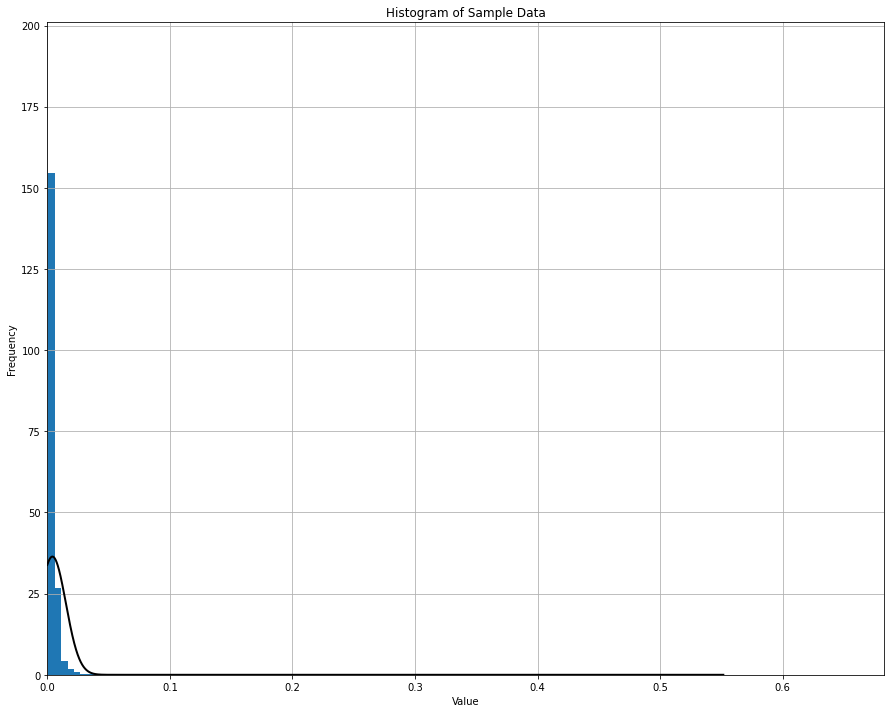

In [319]:
plot_histogram(dataframe["Txn fee"])

Since the histogram is skewed, we apply log transformation on it to have a better visualization:

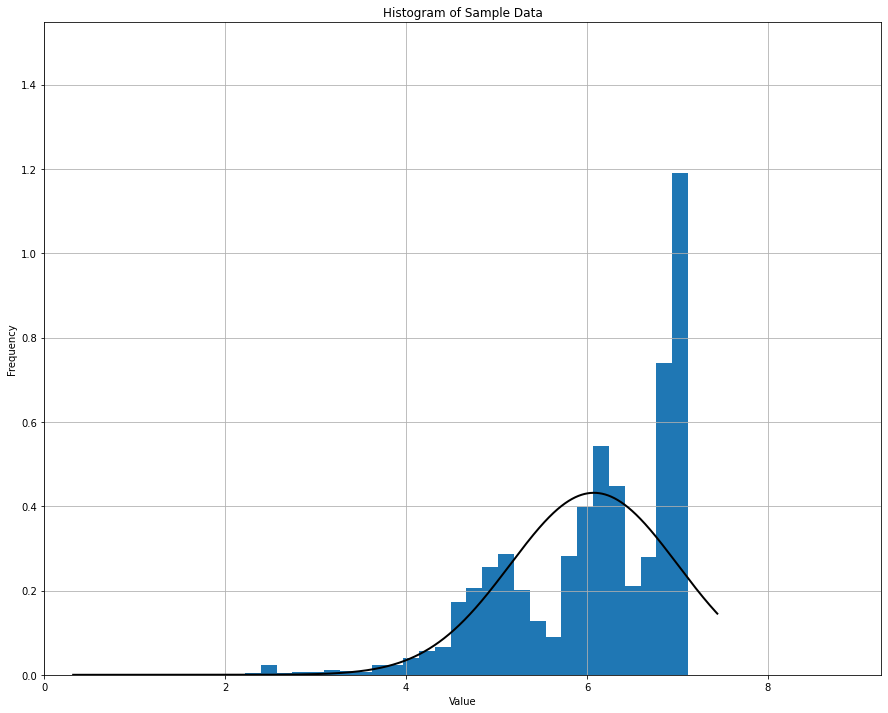

In [320]:
logged_txnFee = np.log(dataframe['Txn fee'] + 0.000001) * -1
plot_histogram(logged_txnFee)

Box Plot:

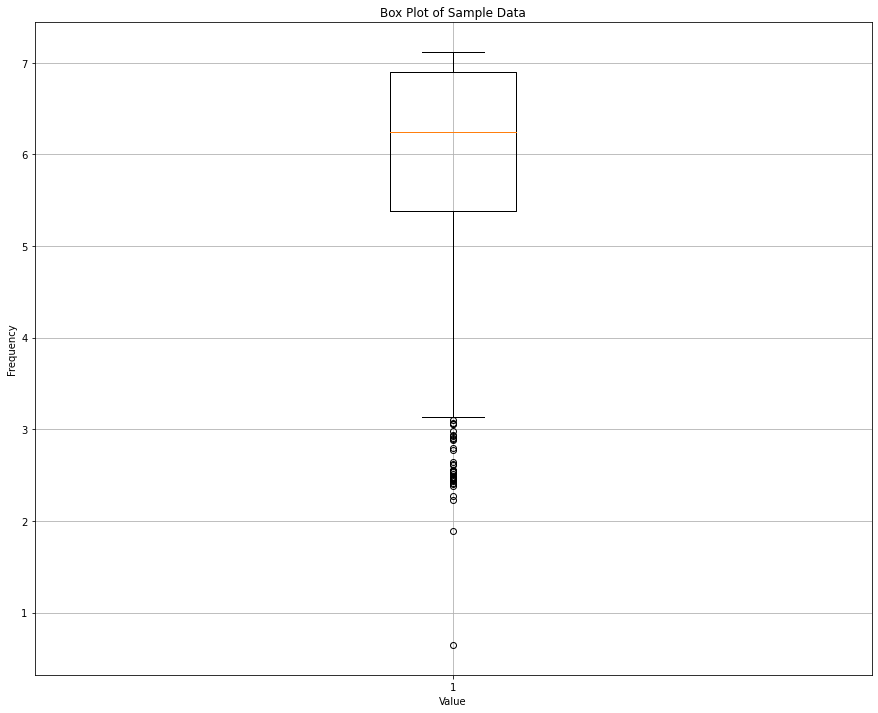

In [331]:
plot_boxPlot(logged_txnFee)

Violin Plot

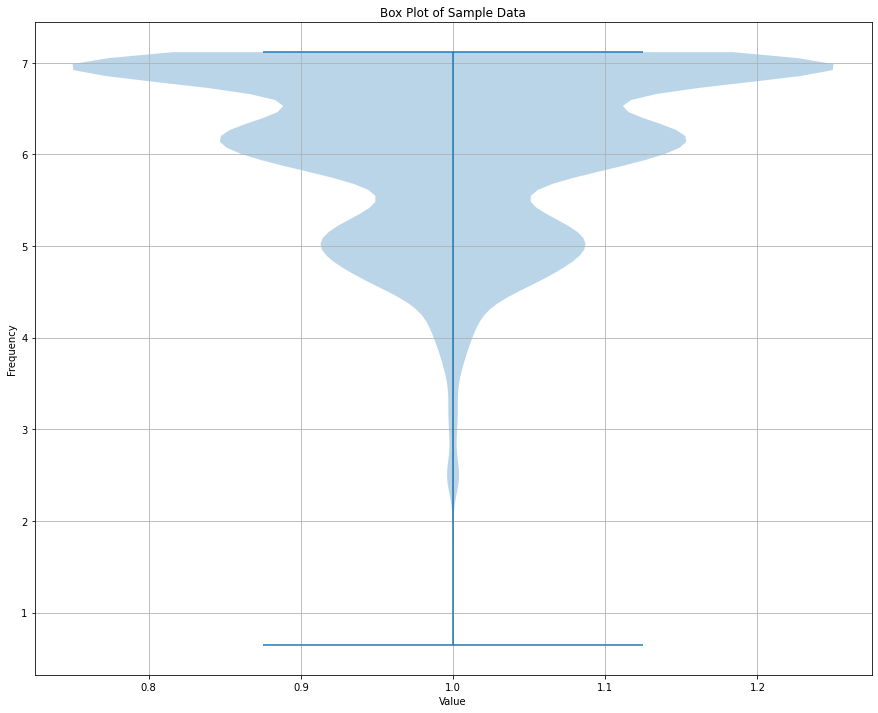

In [332]:
plot_violinPlot(logged_txnFee)

#### Txn Value:

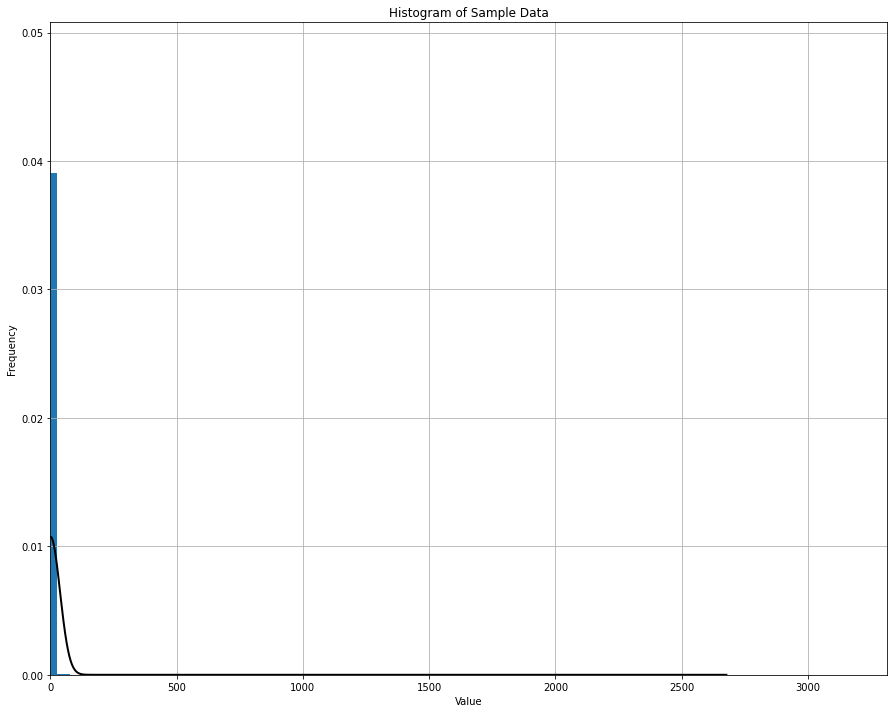

In [322]:
plot_histogram(dataframe["Value"])

Again, we apply the Log transformation due to the high right skewness of the data. 

In [323]:
logged_txnVal = np.log(dataframe['Value'] + 0.000001) * -1
logged_txnVal

0        3.029453
1        7.897512
2        5.587334
3        5.587334
4        2.466877
          ...    
4806    13.815511
4807     3.125648
4808     3.756065
4809     5.703871
4810    13.815511
Name: Value, Length: 4811, dtype: float64

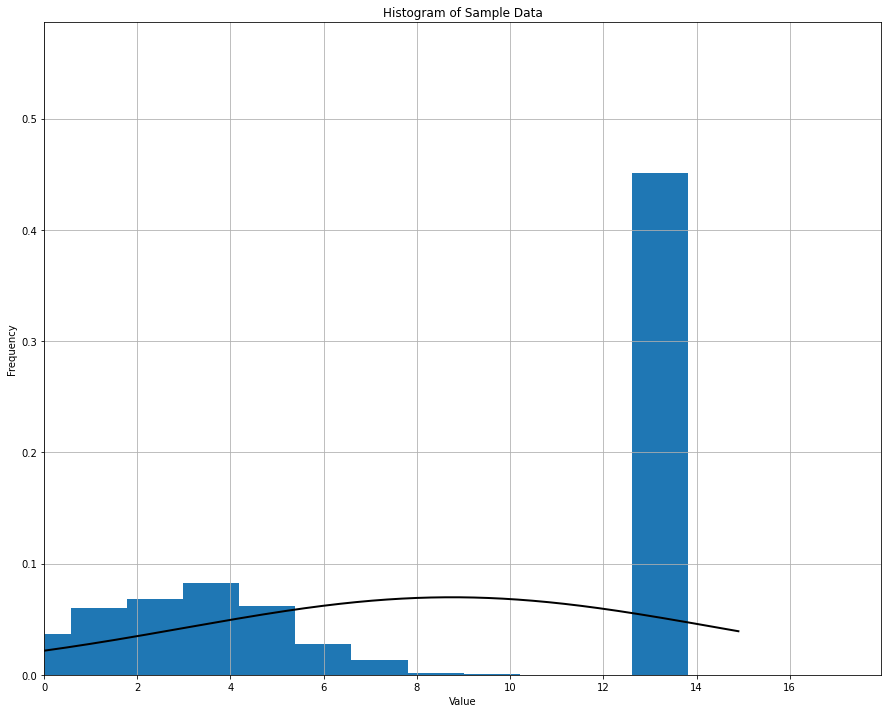

In [324]:
plot_histogram(logged_txnVal)

* Note that we added a small constant $C = 0.000001$ to our target column for handling the $log(0) = infinity$ problem in log transformation. Therefore, the large bin in the log transformed histogram of the transaction value column represent the transactions with 0 transaction value.

Box Plot:

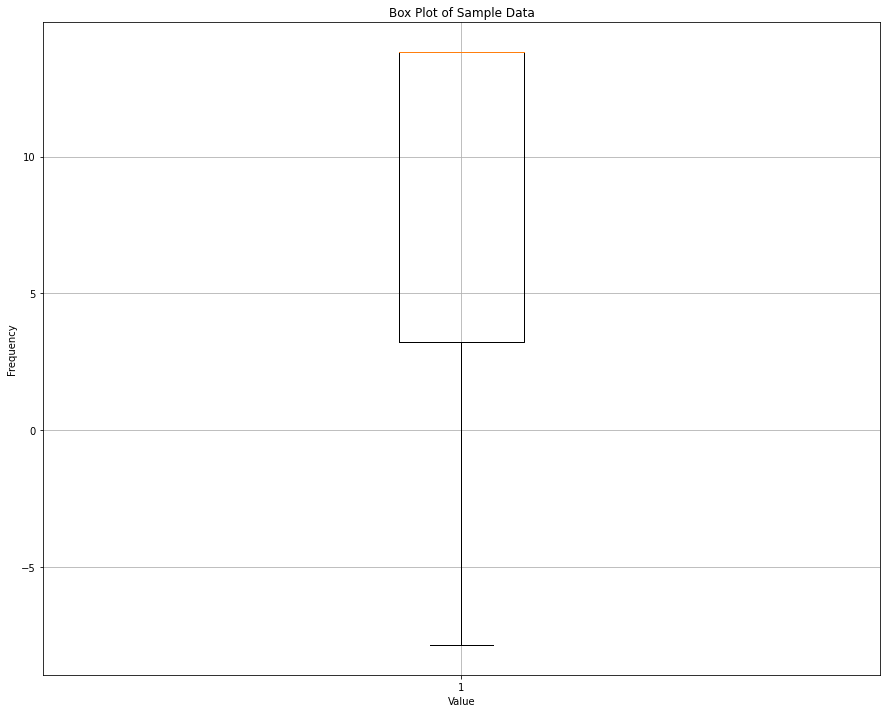

In [333]:
plot_boxPlot(logged_txnVal)

Violin plot:

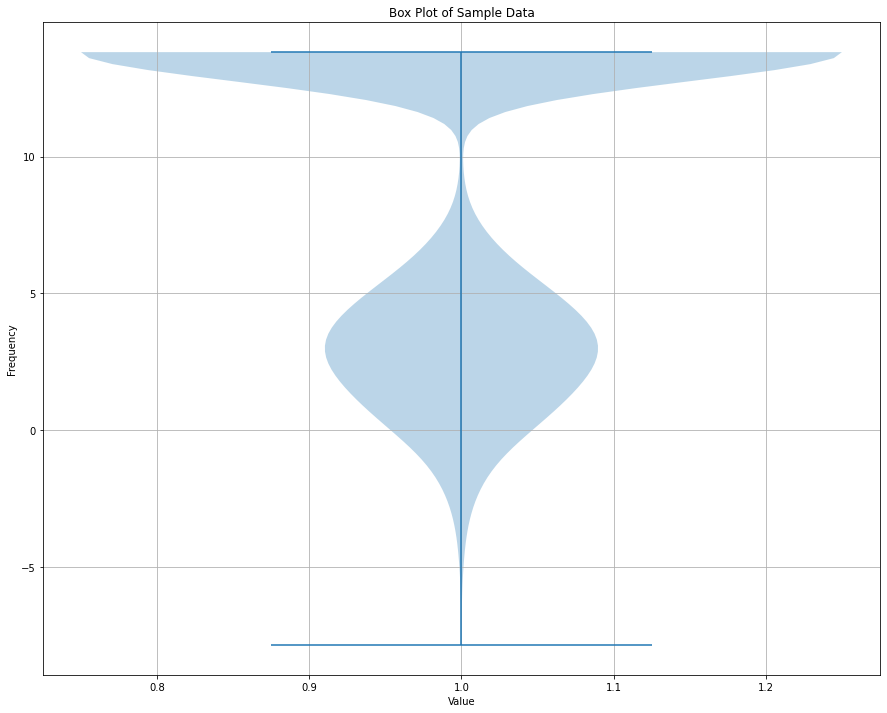

In [334]:
plot_violinPlot(logged_txnVal)

### Method Distribution

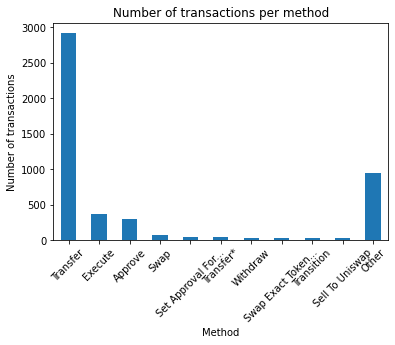

In [325]:
# show the number of transactions per method in a bar chart
# only show the top 10 methods
# show other methods as 'Other'
# show labels 45 degrees rotated
top_methods = dataframe['Method'].value_counts().head(10)
other_methods = dataframe['Method'].value_counts().tail(-10).sum()
top_methods['Other'] = other_methods
top_methods.plot(kind='bar')
plt.title('Number of transactions per method')
plt.xlabel('Method')
plt.ylabel('Number of transactions')
plt.xticks(rotation=45)
plt.show()


### Block Distribution

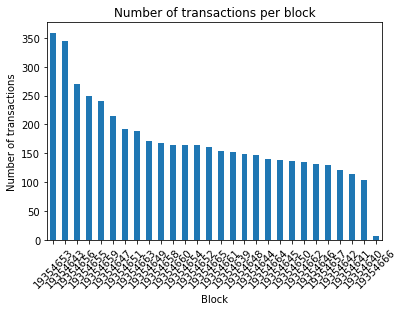

In [326]:
# show the number of transactions per block in a bar chart
dataframe['Block'].value_counts().plot(kind='bar')
plt.title('Number of transactions per block')
plt.xlabel('Block')
plt.ylabel('Number of transactions')
plt.xticks(rotation=45)
plt.show()


### Sender Distribution

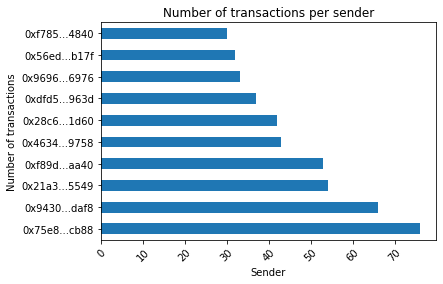

In [327]:
# show the number of transactions for every sender in a bar chart
# only show the top 10 senders
top_senders = dataframe['From'].value_counts().head(10)
top_senders.index = top_senders.index.map(lambda x: x[:6] + '...' + x[-4:])
top_senders.plot(kind='barh')
plt.title('Number of transactions per sender')  
plt.xlabel('Sender')
plt.ylabel('Number of transactions')
plt.xticks(rotation=45)
plt.show()

### Receiver Distribution

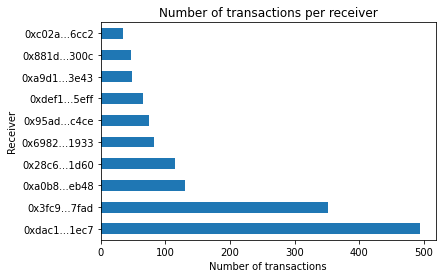

In [328]:
# show the number of transactions for every receiver in a bar chart
# only show the top 10 receivers
# make the bar chart horizontal
top_receivers = dataframe['To'].value_counts().head(10)
top_receivers.index = top_receivers.index.str[:6] + '...' + top_receivers.index.str[-4:]
top_receivers.plot(kind='barh')
plt.title('Number of transactions per receiver')
plt.xlabel('Number of transactions')
plt.ylabel('Receiver')
plt.show()

### Histograms

## Data Sampling and Analysis

In this section, we will delve into the process of data sampling and perform an initial analysis on the transaction data we have collected. Our objective is to understand the distribution of transaction values by sampling the data and comparing the sample statistics with the population statistics.

### Steps

1. **Load the Data**: Import the collected transaction data into a pandas DataFrame.

2. **Data Cleaning**: Clean the data by handling missing values, converting data types, and removing any irrelevant information.

3. **Simple Random Sampling (SRS)**: Create a sample from the dataset using a simple random sampling method. This involves randomly selecting a subset of the data without regard to any specific characteristics of the data.

4. **Stratified Sampling**: Create another sample from the dataset using a stratified sampling method. This involves dividing the data into strata based on a specific characteristic (e.g., transaction value) and then randomly selecting samples from each stratum. Explain what you have stratified the data by and why you chose this column.

5. **Statistical Analysis**: Calculate the mean and standard deviation of the samples and the population. Compare these statistics to understand the distribution of transaction values.

6. **Visualization**: Plot the distribution of transaction values and fees for both the samples and the population to visually compare their distributions.

### Considerations

- **Sample Size**: The size of the sample should be large enough to represent the population accurately but not so large that it becomes impractical to analyze.
- **Sampling Method**: Choose the appropriate sampling method based on the characteristics of the data and the research question.

Explain the above considerations in your report.

In [2]:
df = pd.read_csv('etherscan.csv')

In [3]:
df.describe()

,Block,Local Date,Value,Txn fee
count,4.811000e+03,4.811000e+03,4811.000000,4811.000000
mean,1.935465e+07,1.709469e+09,1.043481,0.004162
std,7.379266e+00,8.855120e+01,37.162876,0.010956
min,1.935464e+07,1.709469e+09,0.000000,0.000810
25%,1.935465e+07,1.709469e+09,0.000000,0.001007
50%,1.935465e+07,1.709469e+09,0.000000,0.001936
75%,1.935466e+07,1.709469e+09,0.040078,0.004577
max,1.935467e+07,1.709469e+09,2549.406700,0.525259


In [4]:
transfer = df[df['Method'] == 'Transfer']
non_transfer = df[df['Method'] != 'Transfer']

transfer_zero = transfer[transfer['Value'] == 0]
non_transfer_zero = non_transfer[non_transfer['Value'] == 0]

print(f'transfer transactions with 0 value: {transfer_zero.shape[0]}')
print(f'percentage of zero value in transfer transactions: {transfer_zero.shape[0] / transfer.shape[0]}\n')
print(f'non transfer transactions with 0 value: {non_transfer_zero.shape[0]}')
print(f'percentage of zero value in non transfer transactions: {non_transfer_zero.shape[0] / non_transfer.shape[0]}')

transfer transactions with 0 value: 1238
percentage of zero value in transfer transactions: 0.4244086390126843

non transfer transactions with 0 value: 1349
percentage of zero value in non transfer transactions: 0.7122492080253432


Transfers with 0 value are mainly used for phishing attacks. Non transfer transactions also isn't needed for our purpose. In this notebook, we want to show assosiation between `value` and `fee` of transactions. So, we will remove these transactions from our dataset.

In [5]:
df = df[~(df['Method'] != 'Transfer')]
df = df[~(df['Value'] == 0)]

In [6]:
# remove outliers using interquartile range
q1 = df['Value'].quantile(0.25)
q3 = df['Value'].quantile(0.75)
iqr = q3 - q1
df = df[~((df['Value'] < (q1 - 1.5 * iqr)) | (df['Value'] > (q3 + 1.5 * iqr)))]
df = df[~(df['Value'] == 0)]


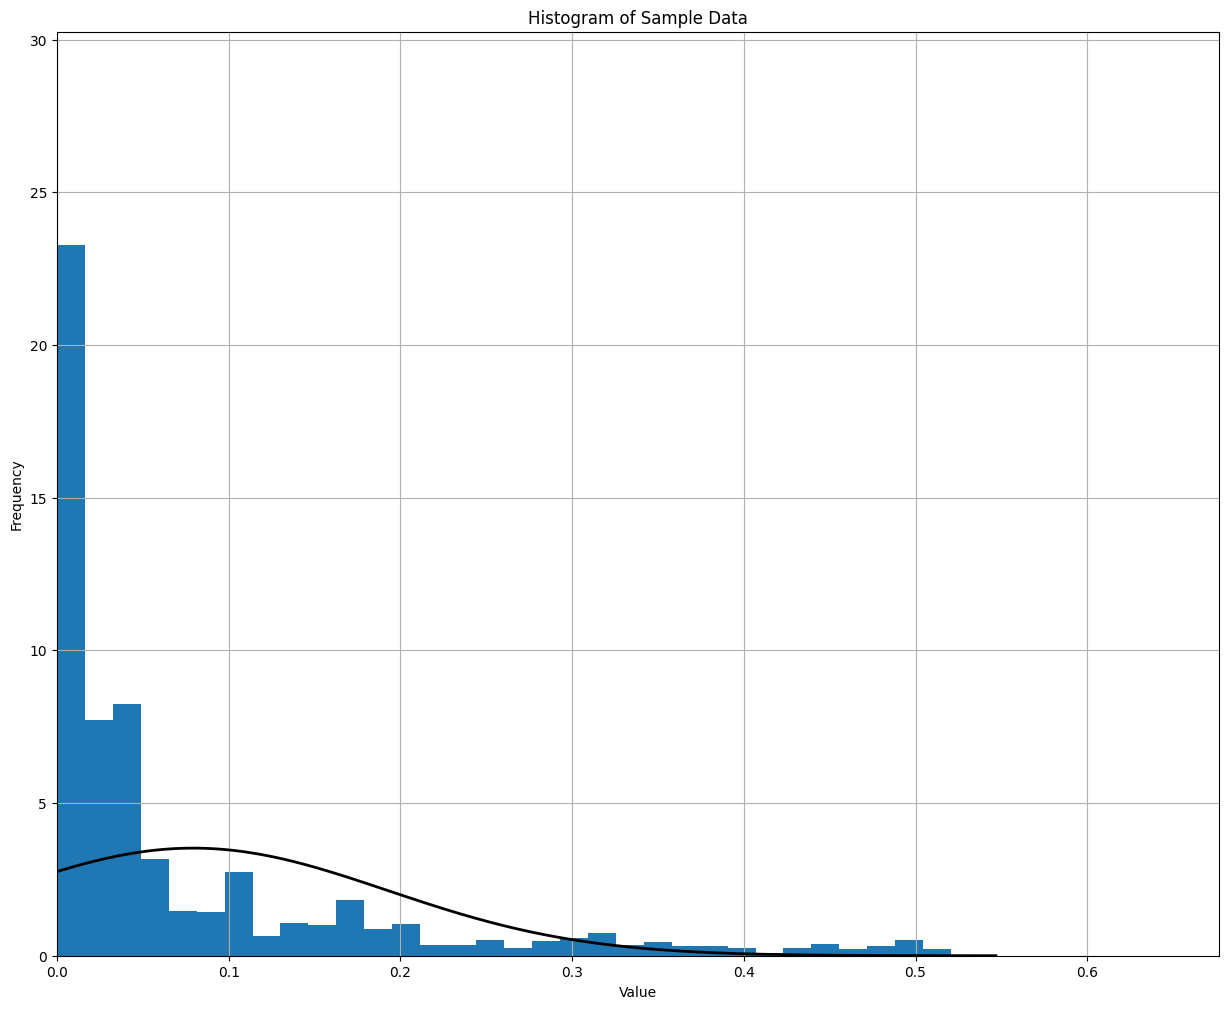

In [13]:
plot_histogram(df['Value'])

In [14]:
# simple random sampling (SRS)
random_sample = df.sample(frac=0.1, random_state=1)

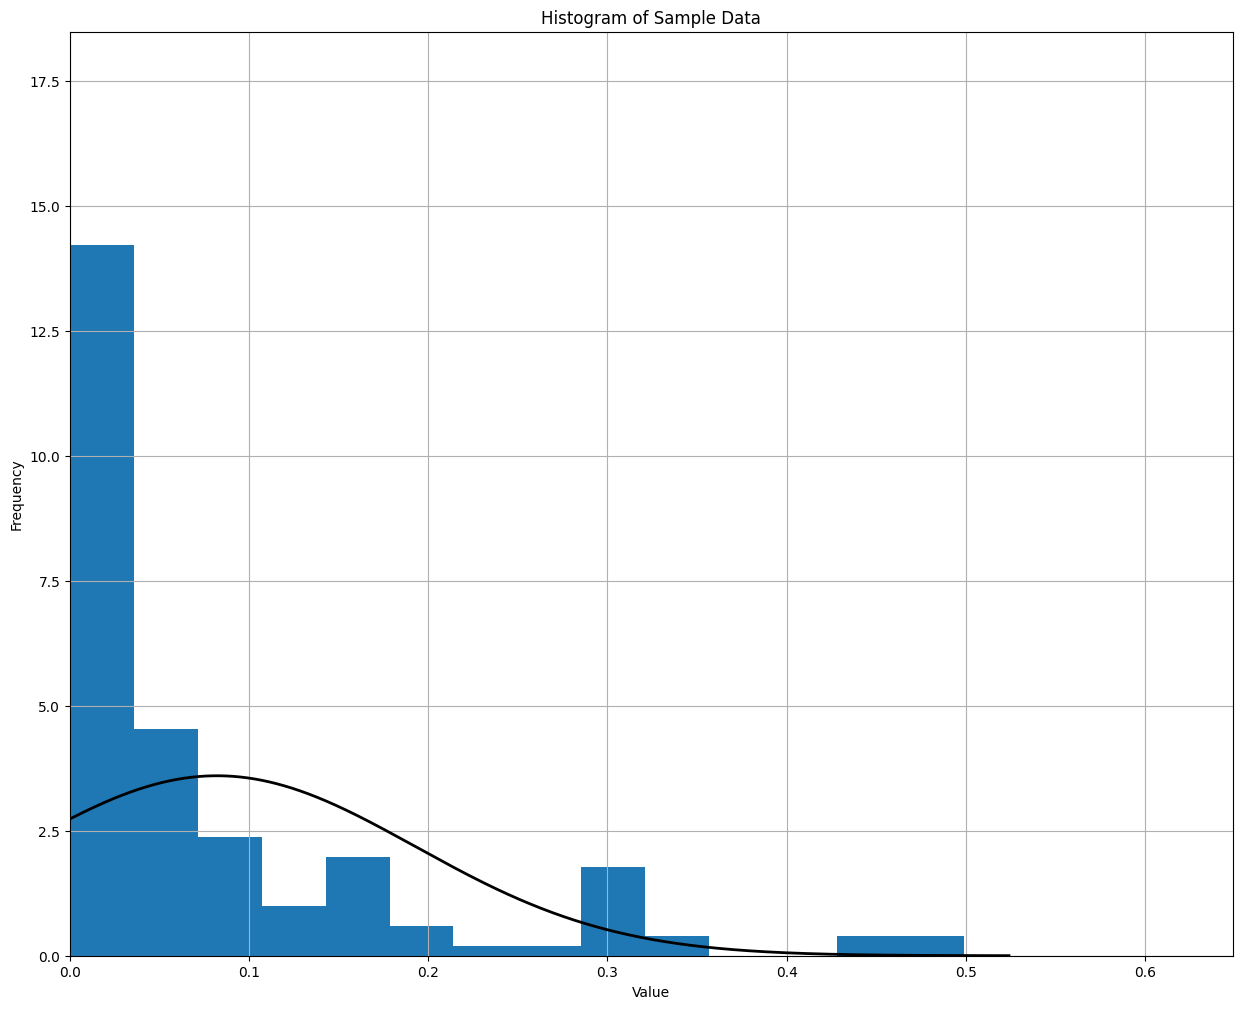

In [15]:
plot_histogram(random_sample['Value'])

In [16]:
# stratified sampling
stratified_sample = df.groupby('Value', group_keys=False).apply(lambda x: x.sample(frac=0.2))
stratified_sample.describe()

,Block,Local Date,Value,Txn fee
count,7.200000e+01,7.200000e+01,72.000000,72.000000
mean,1.935465e+07,1.709469e+09,0.067414,0.001081
std,7.276226e+00,8.731471e+01,0.094150,0.000666
min,1.935464e+07,1.709469e+09,0.000939,0.000810
25%,1.935465e+07,1.709469e+09,0.010000,0.000863
50%,1.935465e+07,1.709469e+09,0.038762,0.000973
75%,1.935466e+07,1.709469e+09,0.100000,0.001050
max,1.935466e+07,1.709469e+09,0.500000,0.006210


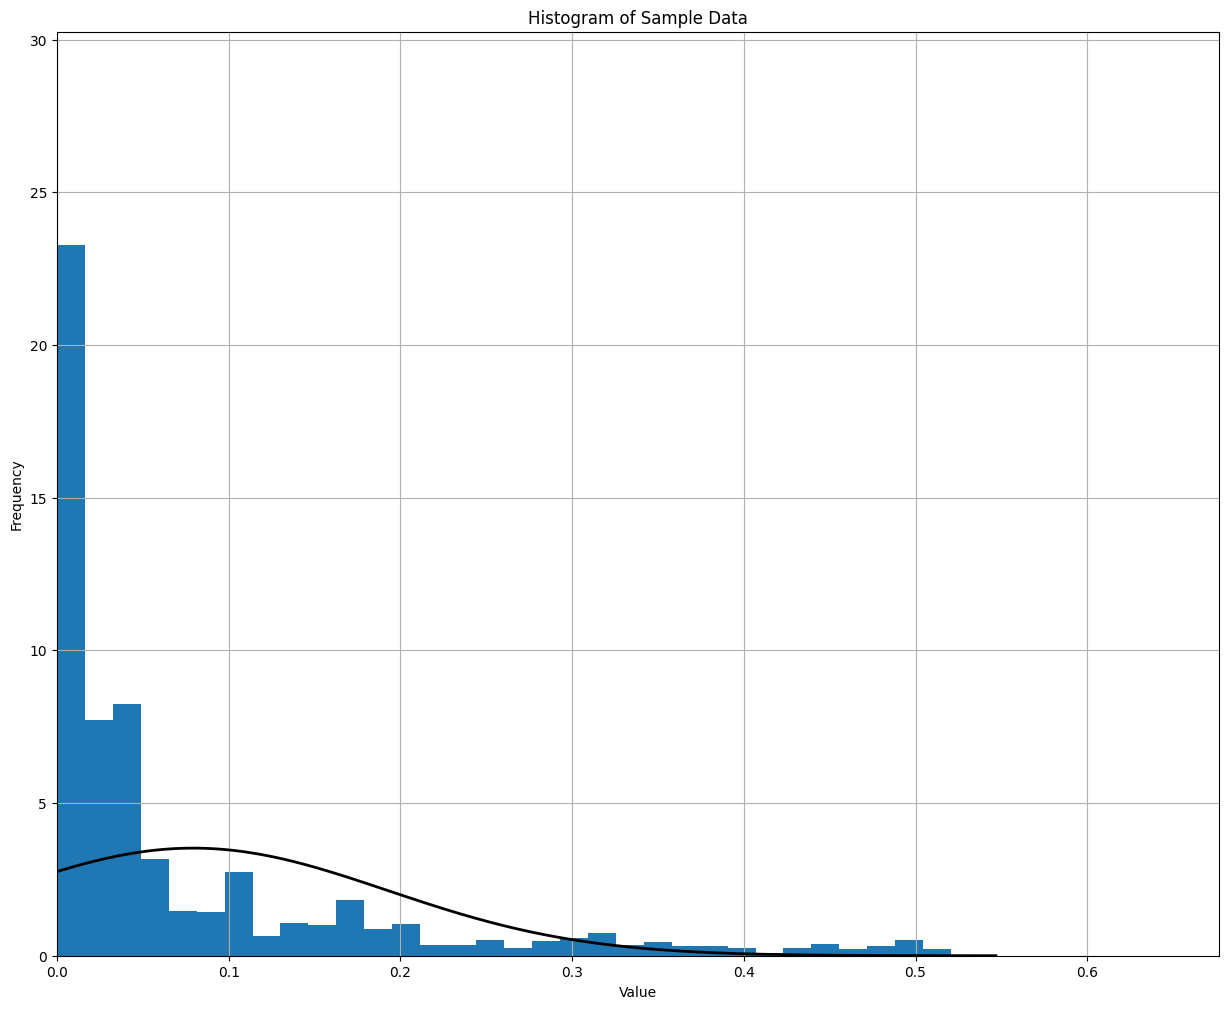

In [17]:
plot_histogram(df['Value'])

In [18]:
headers = ["Datafrmae", "Column", "Mean", "STD"]

data = [
    ["df", "Value", df['Value'].mean(), df['Value'].std()],
    ["random_sample", "Value", random_sample['Value'].mean(), random_sample['Value'].std()],
    ["stratified_sample", "Value", stratified_sample['Value'].mean(), stratified_sample['Value'].std()],
    ["df", "TxnFee", df['Txn fee'].mean(), df['Txn fee'].std()],
    ["random_sample", "Txn fee", random_sample['Txn fee'].mean(), random_sample['Txn fee'].std()],
    ["stratified_sample", "Txn fee", stratified_sample['Txn fee'].mean(), stratified_sample['Txn fee'].std()]
]

table = tabulate(data, headers, tablefmt="grid")
print(table)


+-------------------+----------+------------+-------------+
| Datafrmae         | Column   |       Mean |         STD |
+===================+==========+============+=============+
| df                | Value    | 0.079363   | 0.113244    |
+-------------------+----------+------------+-------------+
| random_sample     | Value    | 0.0820177  | 0.111154    |
+-------------------+----------+------------+-------------+
| stratified_sample | Value    | 0.067414   | 0.09415     |
+-------------------+----------+------------+-------------+
| df                | TxnFee   | 0.00100629 | 0.000422178 |
+-------------------+----------+------------+-------------+
| random_sample     | Txn fee  | 0.00105467 | 0.00051701  |
+-------------------+----------+------------+-------------+
| stratified_sample | Txn fee  | 0.00108059 | 0.000666022 |
+-------------------+----------+------------+-------------+
